## **Section 6: Vanguards-lite Countermeasure**

- Using this notebook, figure 7 in our paper can be obtained.

In [1]:
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from os.path import join, abspath

In [2]:
DATA_DIR = abspath("./2_data_vanguards-lite")

In [3]:
def load_from_json(json_path):
    return json.loads(open(json_path).read())


def load_sim_results(json_path, attack_times):

    # Load simulation result JSON.
    res = load_from_json(json_path)

    # Pretty-format the adversary-controlled share of HSDirs.
    h = "-1"
    if res["n_adv_hsdirs"] == 1:
        h = "1/6"
    elif res["n_adv_hsdirs"] == 2:
        h = "1/3"
    elif res["n_adv_hsdirs"] == 6:
        h = "1"

    # Pretty-format the adversarial relay bandwidth share.
    b = "%d%%" % (100 * float(res["adv_bw_share"]))

    # Extract the initialization value for the token bucket.
    tb_iv = res["n_initial_tokens"]

    # Extract the refill rate for the token bucket.
    tb_refill = res["token_refill_rate"]

    # Extract whether Vanguards-lite was enabled.
    vanguardslite_enabled = False
    if "vanguardslite_enabled" in res:
        vanguardslite_enabled = res["vanguardslite_enabled"]

    simulation_duration = res["simulation_duration"]

    # Append each attack duration with attached metadata to list of all results.
    for timestamp in res["attack_durations"]:
        attack_times.append(
            (h, b, tb_iv, tb_refill, vanguardslite_enabled, timestamp))

### Probability of Having at Least One Malicious Relay in a User's L2 Guard Set

- Vanguards-lite setting: 4 L2 guards
- Simulate using different adversarial bandwidth shares
- Note that `expected_p_of_having_adv_relays = 1 - (1 - adv_bw) ** 4`

In [4]:
ADV_BWS = [0.01, 0.05, 0.1, 0.2]
N_L2_GUARDS = [4]

In [5]:
def pick_new_l2_guards_and_report(adv_bw, n_guards):
    """Pick new l2 guards and report whether at least one of them is malicious."""

    for __ in range(n_guards):
        if random.random() < adv_bw:
            return 1  # adversarial pick

    return 0

In [6]:
N_GUARD_PICK_TRIALS = 10**6

for adv_bw in ADV_BWS:
    
    print("\nadv_bw: %0.3f"  % adv_bw)
    
    for n_l2_guards in N_L2_GUARDS:
        
        results = []
        for __ in range(N_GUARD_PICK_TRIALS):
            results.append(pick_new_l2_guards_and_report(adv_bw, n_l2_guards))

        simulated_p_of_compromise = sum(results)/len(results)
        expected_p_of_compromise = 1 - (1-adv_bw) ** n_l2_guards

        print("N_L2_GUARDS: %d P_expected: %0.5f P_simulated: %0.5f "  % (n_l2_guards, expected_p_of_compromise, simulated_p_of_compromise))


adv_bw: 0.010
N_L2_GUARDS: 4 P_expected: 0.03940 P_simulated: 0.03946 

adv_bw: 0.050
N_L2_GUARDS: 4 P_expected: 0.18549 P_simulated: 0.18541 

adv_bw: 0.100
N_L2_GUARDS: 4 P_expected: 0.34390 P_simulated: 0.34417 

adv_bw: 0.200
N_L2_GUARDS: 4 P_expected: 0.59040 P_simulated: 0.59021 


### Key Points

- **5% adversary => 18.5% of the users expected to have at least one adversarial relay in their L2 set**
- **10% adversary => 34% of the users expected to have at least one adversarial relay in their L2 set**

### Scenario 1: Targeting an Individual Victim

Consider a victim targeted by an adversary with 5% bandwidth share. The adversary sends the victim a malicious link, which the victim visits using Tor Browser.

**With 81.5% probability (1 - 0.185), the victim will not have a malicious relay in their L2 set and be safe from our attack.**

### Scenario 2: Targeting a Website's Visitors

Consider an adversary (5% bandwidth share) who targets the visitors of a sensitive website.

**The adversary will be able to discover the guards of 18.5% of the website's visitors.**

In [7]:
attack_times = []

for json_path in glob(join(DATA_DIR, "time_to_double_comp_*.json")):
    load_sim_results(json_path, attack_times)

In [8]:
df = pd.DataFrame(attack_times, columns=["h", "b", "tb_iv", "tb_refill", "vanguardslite_enabled", "attack_duration"])
df.head(15)

,h,b,tb_iv,tb_refill,vanguardslite_enabled,attack_duration
0,1/6,5%,0,0,True,4.6295
1,1/6,5%,0,0,True,4.5000
2,1/6,5%,0,0,True,10.2310
3,1/6,5%,0,0,True,8.9465
4,1/6,5%,0,0,True,10.9085
5,1/6,5%,0,0,True,4.7190
6,1/6,5%,0,0,True,2.5475
7,1/6,5%,0,0,True,7.2965
8,1/6,5%,0,0,True,5.0115
9,1/6,5%,0,0,True,3.0945


In [9]:
assert df["vanguardslite_enabled"].any() == True
assert df["vanguardslite_enabled"].all() == True
assert df["tb_iv"].astype(bool).any() == False
assert df["tb_iv"].astype(bool).all() == False
assert df["tb_refill"].astype(bool).any() == False
assert df["tb_refill"].astype(bool).all() == False

In [10]:
pd.options.display.float_format = "{:,.2f}".format

df.groupby(["vanguardslite_enabled", "b", "h"]).attack_duration.describe(percentiles=[0.25, 0.50, 0.90, 0.95, 0.99])

count  mean   std  min  25%  50%   90%  \
vanguardslite_enabled b  h                                                 
True                  5% 1   143,350.00  3.75  5.28 0.19 2.33 3.11  5.37   
                         1/3 143,350.00  6.05  8.94 0.30 3.73 5.13  8.88   
                         1/6 143,350.00  8.45 11.08 0.34 5.21 7.22 12.47   

                               95%   99%    max  
vanguardslite_enabled b  h                       
True                  5% 1    6.65 17.52 300.00  
                         1/3 10.65 21.31 300.00  
                         1/6 14.83 26.76 300.00

In [11]:
pd.options.display.float_format = "{:,.2f}".format

df_h_one_two = df[(df["h"] == "1/3") | (df["h"] == "1/6")]
df_h_one_two.groupby(["b", "h", "tb_iv", "tb_refill"]).attack_duration.describe(percentiles=[0.25, 0.50, 0.90, 0.95, 0.99])

count  mean   std  min  25%  50%   90%   95%  \
b  h   tb_iv tb_refill                                                     
5% 1/3 0     0         143,350.00  6.05  8.94 0.30 3.73 5.13  8.88 10.65   
   1/6 0     0         143,350.00  8.45 11.08 0.34 5.21 7.22 12.47 14.83   

                         99%    max  
b  h   tb_iv tb_refill               
5% 1/3 0     0         21.31 300.00  
   1/6 0     0         26.76 300.00

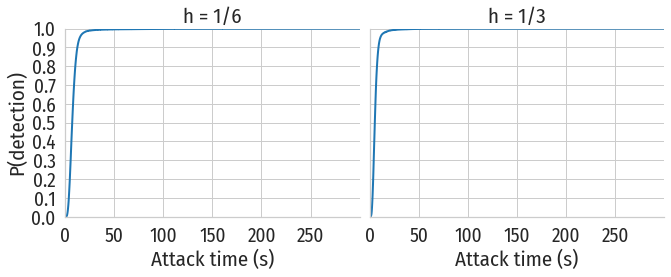

In [12]:
SIMULATION_DURATION = 299.9

sns.set()
sns.set(style="whitegrid", font_scale=1.75)
sns.set_style({"font.family": "Fira Sans Condensed"})

colors = {"1/6": "tab:red", "1/3": "tab:red", "1": "tab:red"}

fig = sns.displot(
    df_h_one_two, x = "attack_duration", col = "h",
    kind = "ecdf", height = 3.65, aspect = 1.25, legend = False,
    facet_kws = dict(margin_titles=True), lw = 2.0,
    col_order = ("1/6", "1/3"),
    color = "tab:blue",
)

fig.set_axis_labels(x_var = "Attack time (s)", y_var = "P(detection)")
fig.set_titles("")

fig.set(xlim=(0.0, SIMULATION_DURATION), ylim=(0.0, 1.0),
        xticks=np.arange(0.0, SIMULATION_DURATION, 50.0),
        yticks=np.arange(0.0, 1.1, 0.1))

plt.tight_layout(pad = 0.0, w_pad = 0.25, h_pad = 0.0)

plt.show()